In [1]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, LSTM
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import root_mean_squared_error


# Carga y Preparación de data

In [2]:
consumo = pd.read_excel("CONSUMO-2024-06.xlsx", skiprows = 6)
importacion = pd.read_excel("IMPORTACION-VOLUMEN-2024-06.xlsx", skiprows = 6)
precios2024 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2024", skiprows = 9, header = None, 
                        names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2023 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2023", skiprows = 9, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2022 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2022", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])
precios2021 = pd.read_excel("Precios-Promedio-Nacionales-Diarios-2024-2.xlsx", sheet_name = "2021", skiprows = 8, header = None,
                            names = ["Fecha", "Tipo de Cambio", "Superior", "Regular", "Diesel", "Bunker", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", 
                                 "Glp Cilindro 25Lbs. (GTQ/LB)"])

In [3]:
precios2024.drop(precios2024.tail(9).index, inplace = True)
precios2023.drop(precios2023.tail(2).index, inplace = True)
precios2022.drop(precios2022.tail(2).index, inplace = True)
precios2021.drop(precios2021.tail(2).index, inplace = True)

In [4]:
precios = pd.concat([precios2021, precios2022, precios2023, precios2024], ignore_index = True)

In [5]:
#Se suman los consumos de Diesel, ya que de 2000 a 2018 se consumía alto en azufre y a partir de enero 2018 se consumía bajo en azufre
consumo["Diesel"] = consumo["Diesel bajo azufre"]+consumo["Diesel alto azufre"]
importacion["Diesel"] = importacion["Diesel bajo azufre"]+importacion["Diesel alto azufre"]

In [6]:
consumo = consumo[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
importacion = importacion[["Fecha", "Diesel", "Gas licuado de petróleo", "Gasolina regular", "Gasolina superior"]].copy()
precios = precios[["Fecha", "Diesel", "Glp Cilindro 25Lbs (GTQ/CIL 25 LB)", "Regular", "Superior"]].copy()

In [7]:
consumo.drop(consumo.tail(3).index, inplace = True)
importacion.drop(importacion.tail(3).index, inplace = True)

In [8]:
consumo["Fecha"] = pd.to_datetime(consumo["Fecha"])
importacion["Fecha"] = pd.to_datetime(importacion["Fecha"])
precios["Fecha"] = pd.to_datetime(precios["Fecha"])

# Modelos LSTM

In [9]:
tf.random.set_seed(1122)

## Consumo Gasolina Regular

In [10]:
regular = consumo[["Fecha", "Gasolina regular"]].copy()
regular.set_index("Fecha", inplace = True)
regular.head()


,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34


In [11]:
print("Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular")
regularTest = adfuller(regular, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para la serie de tiempo de consumo de gasolina regular
Estadístico de prueba          2.430669
p-value                        0.999024
# de retardos usados          14.000000
# de observaciones usadas    279.000000
Critical Value (1%)           -3.454008
Critical Value (5%)           -2.871956
Critical Value (10%)          -2.572320
dtype: float64


El valor-p de la prueba ADF confirma que no es una serie de tiempo estacionaria en media. Por lo tanto, es necesario diferenciarla.

In [12]:
print("Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular")
regular_diff = regular.diff()
regular_diff.fillna(0,inplace = True)
regularTest = adfuller(regular_diff, autolag = "AIC")
salidaDf = pd.Series(regularTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in regularTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Prueba de Dickey-Fuller para una diferenciación de la serie de tiempo de importación de gasolina regular
Estadístico de prueba         -4.316925
p-value                        0.000415
# de retardos usados          16.000000
# de observaciones usadas    277.000000
Critical Value (1%)           -3.454180
Critical Value (5%)           -2.872031
Critical Value (10%)          -2.572360
dtype: float64


El valor-p confirma que con una diferenciación es suficiente para que la serie de tiempo sea estacionaria en media.

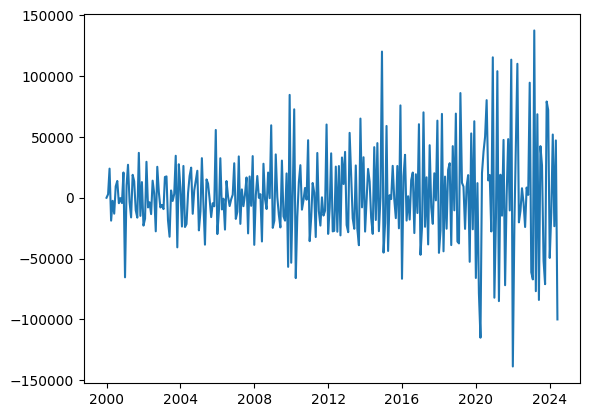

In [13]:
plt.plot(regular_diff)

In [14]:
scaler = StandardScaler()
regular_diff_scaled = scaler.fit_transform(regular_diff)

Separación entre set de entrenamiento y testeo (igual al laboratorio 2)

In [15]:
num_separacion = consumo.index[consumo["Fecha"]==pd.to_datetime("2021-12")][0]
num_val = int(len(regular_diff_scaled)*0.1)
train = regular_diff_scaled[:num_separacion-num_val]
validation = regular_diff_scaled[num_separacion-num_val:num_separacion]
test = regular_diff_scaled[num_separacion:]
#train = regular_diff[:num_separacion]
#test = regular_diff[num_separacion:]

In [16]:
def df_a_X_y(df,retrasos = 1):
    if type(df) is pd.DataFrame:
        df_as_np = df.to_numpy()
    else:
        df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-retrasos):
        row = [a for a in df_as_np[i:(i+retrasos)]]
        X.append(row)
        label = df_as_np[i+retrasos][0]
        y.append(label)
        
    return np.array(X), np.array(y)


retrasos = 1
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

### Creación primer modelo

In [17]:
modelo1 = Sequential()

modelo1.add(InputLayer((retrasos, 1)))
modelo1.add(LSTM(64))
modelo1.add(Dense(8, 'relu'))
modelo1.add(Dense(1, 'linear'))
modelo1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
modelo1.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [19]:
epocas = 50
history= modelo1.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4354 - val_loss: 2.2118
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4230 - val_loss: 2.1867
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4166 - val_loss: 2.1643
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4105 - val_loss: 2.1443
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4048 - val_loss: 2.1236
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3992 - val_loss: 2.1033
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3936 - val_loss: 2.0834
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3875 - val_loss: 2.0612
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3791 - val_loss: 2.0419
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3736 - val_loss: 2.0268
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3693 - val_loss: 2.0170
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3660 - val_loss: 2.0096
Epoch 13/50


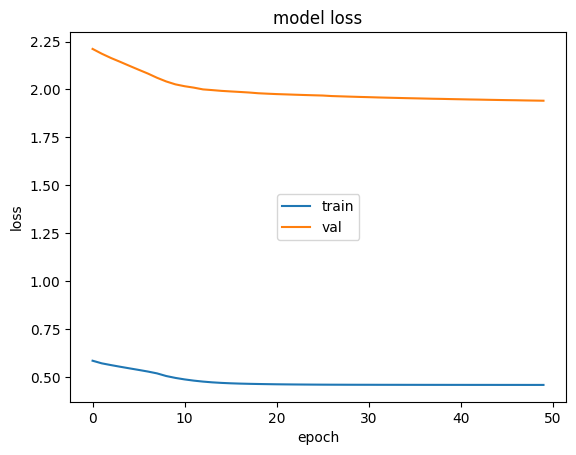

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [21]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3600 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9413
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.2731


2.273085832595825

In [22]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1, retrasos = 1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+retrasos-1+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

In [23]:
prediccion_train = prediccion_fun(x_train,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

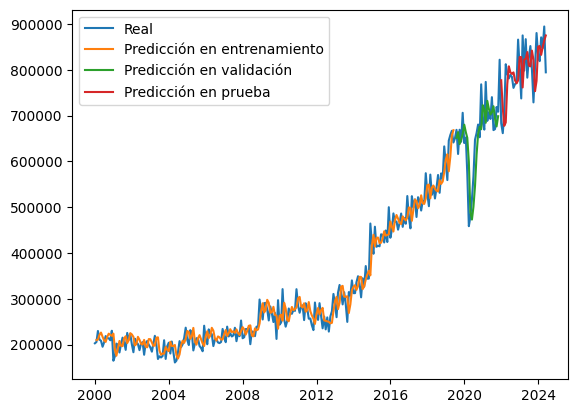

In [24]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[1:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+1:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+1:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Los errores de los modelos generados en el laboratorio 2 son los siguientes:

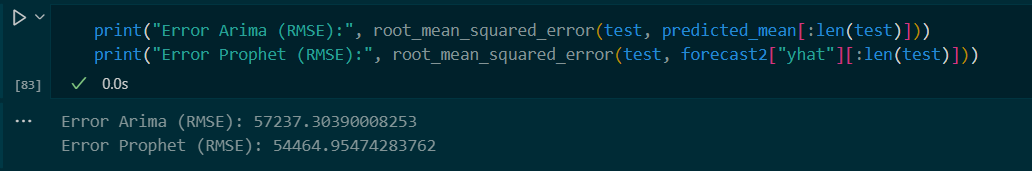

In [25]:
from IPython.display import Image
Image("C:/Users/PMarr/Documents/Documents/GitHub/lab03DS/ErroresRegular.png")

Error del primer LSTM:

In [26]:
print("RMSE modelo1 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo1 (sobre el conjunto de prueba): 58653.501422680274


### Creación segundo modelo

In [108]:
retrasos = 2
x_train,y_train = df_a_X_y(train, retrasos)
x_val,y_val = df_a_X_y(validation, retrasos)
x_test,y_test = df_a_X_y(test, retrasos)

modelo2 = Sequential()

modelo2.add(InputLayer((retrasos, 1)))
modelo2.add(LSTM(64))
modelo2.add(Dense(16, 'relu'))
modelo2.add(Dense(8, 'relu'))
modelo2.add(Dense(1, 'linear'))
modelo2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,081 (70.63 KB)

 Trainable params: 18,081 (70.63 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
modelo2.compile(loss=MeanSquaredError(),optimizer="rmsprop")

In [110]:
epocas = 100
history= modelo2.fit(
    x = x_train,
    y = y_train,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val, y_val)
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.4274 - val_loss: 2.2749
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4020 - val_loss: 2.2489
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3901 - val_loss: 2.2297
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3814 - val_loss: 2.2110
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3745 - val_loss: 2.1970
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3685 - val_loss: 2.1812
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3637 - val_loss: 2.1687
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3593 - val_loss: 2.1544
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3556 - val_loss: 2.1373
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3522 - val_loss: 2.1227
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3490 - val_loss: 2.1084
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3459 - val_loss: 2.0965


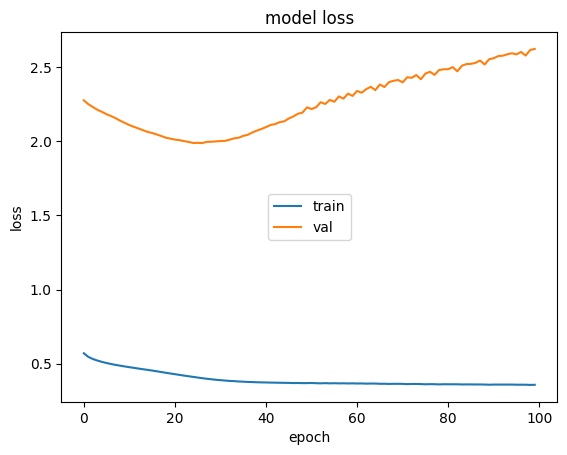

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [112]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3058 
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6214
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9849


1.984918475151062

In [113]:
prediccion_train = prediccion_fun(x_train,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values, n=0, retrasos = retrasos)
prediccion_val = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion-num_val, retrasos = retrasos)
prediccion_test = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = regular.values , n=num_separacion, retrasos = retrasos)

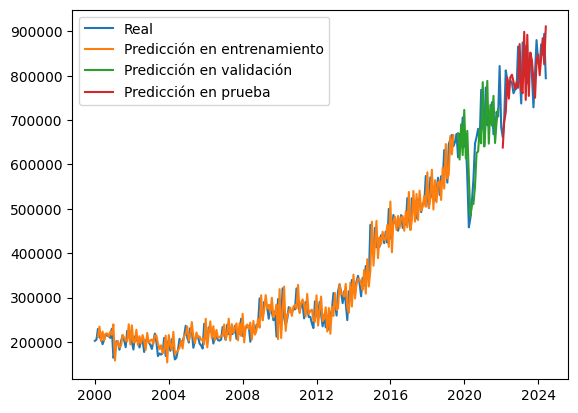

In [114]:
df_train = pd.DataFrame(prediccion_train, columns = ["Predicción en entrenamiento"], index = regular[retrasos:num_separacion-num_val].index)
df_val = pd.DataFrame(prediccion_val, columns = ["Predicción en validación"], index = regular[num_separacion-num_val+retrasos:num_separacion].index)
df_test = pd.DataFrame(prediccion_test, columns = ["Predicción en prueba"], index = regular[num_separacion+retrasos:].index)

plt.plot(regular, label = "Real")
plt.plot(df_train, label = "Predicción en entrenamiento")
plt.plot(df_val, label = "Predicción en validación")
plt.plot(df_test, label = "Predicción en prueba")
plt.legend()
plt.show()

Error del segundo LSTM:

In [115]:
print("RMSE modelo2 (sobre el conjunto de prueba):", root_mean_squared_error(regular[num_separacion+retrasos:], df_test))

RMSE modelo2 (sobre el conjunto de prueba): 62299.58046168294


## Importación Diesel

In [116]:
diesel = importacion[['Fecha', 'Diesel']].copy()
diesel.set_index('Fecha', inplace = True)

train_size = int(len(diesel) * 0.8)
train_diesel = diesel[0:train_size]
test_diesel = diesel[train_size:len(diesel)]

ts_diesel = train_diesel['Diesel']